In [126]:
import torch
import pandas as pd

from GraphDataset import MyDataset
from torch_geometric.loader import DataLoader


In [127]:
# Load soft labels with membership level to each cover

df_data = pd.read_csv('data/ReyZamuro_softLabels.csv',index_col=0)
df_data = df_data.drop('RZUB02')
df_data = df_data.drop('RZUA03b')
print(df_data.head())

                   1         2         3
field_numb                              
RZUA01      1.000000  0.000000  0.000000
RZUA02      1.000000  0.000000  0.000000
RZUA04      0.589278  0.410722  0.000000
RZUA05      0.892664  0.000000  0.107336
RZUA06      0.938423  0.000000  0.061577


In [128]:
#Create list of ARUs and labels

DatosN = list(df_data.index)
Clases = df_data.values.argmax(1)
etiquetasN = Clases

In [129]:
features = 'PANNs'#'PANNs'#'YAMNet' #'VGGish'#'AI'

train_dataset = MyDataset(ListaArchivos=DatosN,
                          etiquetas=etiquetasN, caract=features)
print(len(train_dataset))

92


In [130]:
unpacked_data = [train_dataset[i][0] for i in range(len(train_dataset))]
x = torch.stack(unpacked_data, dim=0).transpose(0,1)

0
RZUA01
file_path='/media/andrescastro/Seagate Backup Plus Drive/AECO/DeepFeatures_data/ReyZamuro/RZUA01_panns.pickle'
n_feat=2048
10
11
12
13
14
15
16
17
18
19
20
21
22
23
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
0
1
2
3
4
5
6
7
8
9
Data1.shape=torch.Size([3, 24, 2048])
1
RZUA02
file_path='/media/andrescastro/Seagate Backup Plus Drive/AECO/DeepFeatures_data/ReyZamuro/RZUA02_panns.pickle'
n_feat=2048
10
11
12
13
14
15
16
17
18
19
20
21
22
23
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
0
1
2
3
4
5
6
7
8
9
Data1.shape=torch.Size([3, 24, 2048])
2
RZUA04
file_path='/media/andrescastro/Seagate Backup Plus Drive/AECO/DeepFeatures_data/ReyZamuro/RZUA04_panns.pickle'
n_feat=2048
10
11
12
13
14
15
16
17
18
19
20
21
22
23
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20

In [131]:
x.shape

torch.Size([3, 92, 24, 2048])

## Edge Creation

In [132]:
from utils import edge_creation_nodeinfo, is_connected, edge_creation_geoDistance, plot_distance_matrix_heatmap, edge_creation_coverinfo
from torch_geometric.utils import is_undirected

In [133]:
graphs = edge_creation_coverinfo(torch.tensor(df_data.values), x,'knn', k_neigh=11)
for i in graphs:
    print(f"Is the graph {i} connected? {is_connected(i)}")
    print(f'Is the graph undirected {is_undirected(i.edge_index)}')

Is the graph Data(x=[92, 24, 2048], edge_index=[2, 1260]) connected? True
Is the graph undirected True
Is the graph Data(x=[92, 24, 2048], edge_index=[2, 1260]) connected? True
Is the graph undirected True
Is the graph Data(x=[92, 24, 2048], edge_index=[2, 1260]) connected? True
Is the graph undirected True


In [134]:
graphs_ = edge_creation_nodeinfo(x,'knn', k_neigh=93)
for i in graphs_:
    print(f"Is the graph {i} connected? {is_connected(i)}")
    print(f'Is the graph undirected {is_undirected(i.edge_index)}')

Is the graph Data(x=[92, 24, 2048], edge_index=[2, 8372]) connected? True
Is the graph undirected True
Is the graph Data(x=[92, 24, 2048], edge_index=[2, 8372]) connected? True
Is the graph undirected True
Is the graph Data(x=[92, 24, 2048], edge_index=[2, 8372]) connected? True
Is the graph undirected True


In [135]:
df_map = pd.read_csv('./data/ReyZamuro_latlon.csv',index_col='field_numb')
df_map = df_map.drop('RZUA03b')

In [136]:
graphs_, adjacency_matrix = edge_creation_geoDistance(x, df_map)

In [137]:
for i in graphs_:
    print(f"Is the graph {i} connected? {is_connected(i)}")
    print(f'Is the graph undirected {is_undirected(i.edge_index)}')

Is the graph Data(x=[92, 24, 2048], edge_index=[2, 1400]) connected? True
Is the graph undirected True
Is the graph Data(x=[92, 24, 2048], edge_index=[2, 1400]) connected? True
Is the graph undirected True
Is the graph Data(x=[92, 24, 2048], edge_index=[2, 1400]) connected? True
Is the graph undirected True


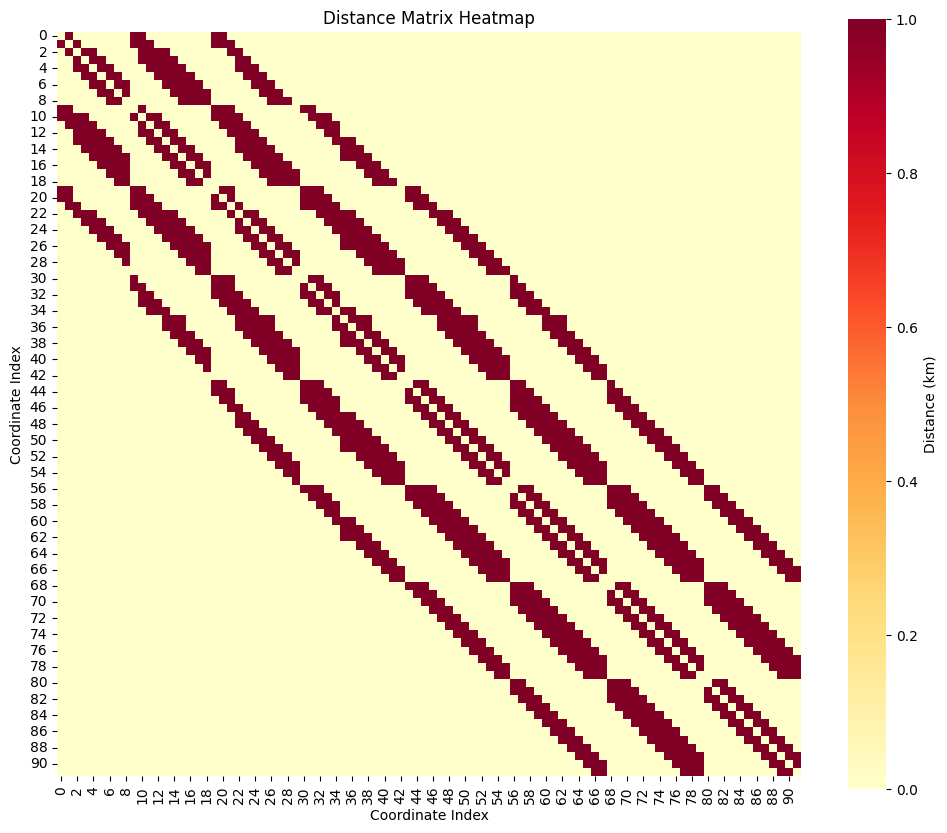

In [138]:
plot_distance_matrix_heatmap(adjacency_matrix)

In [139]:
train_loader = DataLoader(graphs, batch_size=1, shuffle=False)

## Organizar de acá en adelante

In [140]:
import torch
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from torch_geometric.data import Data
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import numpy as np

class MatrixGCN(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, embedding_dim):
        super(MatrixGCN, self).__init__()
        self.conv1d = torch.nn.Conv1d(1, 64, 24, stride=24)
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, embedding_dim)

    def forward(self, x, edge_index):
        x = x.transpose(1,2).flatten(1)  # Flatten the matrix features
        x = self.conv1d(x.unsqueeze(1))
        x = x.view(x.size(0),-1)
        #print(x.shape)
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.conv2(x, edge_index)
        return x

# Initialize model and optimizer
model = MatrixGCN(in_channels=64*2048, hidden_channels=2048, embedding_dim=8)#num_filters conv1d x num_original_features
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)


# Unsupervised loss function (e.g., graph regularization)
def unsupervised_loss(embedding, edge_index):
    # This loss encourages connected nodes to have similar embeddings
    src, dst = edge_index
    distance = F.pairwise_distance(embedding[src], embedding[dst])
    return distance.mean()

# Training function
def train():
    model.train()
    model.double()
    for graph in train_loader:
        optimizer.zero_grad()
        embedding = model(graph.x.double(), graph.edge_index)
        loss = unsupervised_loss(embedding, graph.edge_index)
        loss.backward()
        optimizer.step()
    return loss.item()

# Train the model
for epoch in range(1, 12): #Oversmoothing?
    loss = train()
    if epoch % 3 == 0:
        print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}')

Epoch: 003, Loss: 6.9002
Epoch: 006, Loss: 4.9655
Epoch: 009, Loss: 1.8612


In [141]:
# Generate embeddings
model.eval()
with torch.no_grad():
    for graph in train_loader:
        embeddings = model(graph.x.double(), graph.edge_index)

# Function to perform clustering and evaluate
def cluster_and_evaluate(embeddings, n_clusters):
    kmeans = KMeans(n_clusters=n_clusters, n_init=10, random_state=42)
    clusters = kmeans.fit_predict(embeddings.numpy())
    silhouette_avg = silhouette_score(embeddings.numpy(), clusters)
    return clusters, silhouette_avg

# Try different numbers of clusters
best_n_clusters = 0
best_silhouette = -1
for n_clusters in range(2, 10):  # Try 2 to 10 clusters
    clusters, silhouette_avg = cluster_and_evaluate(embeddings, n_clusters)
    print(f"For n_clusters = {n_clusters}, the average silhouette score is : {silhouette_avg}")
    if silhouette_avg > best_silhouette:
        best_silhouette = silhouette_avg
        best_n_clusters = n_clusters

print(f"\nBest number of clusters: {best_n_clusters}")

# Perform final clustering with the best number of clusters
final_clusters, _ = cluster_and_evaluate(embeddings, best_n_clusters)

print("\nFinal Clustering Results:")
for i in range(best_n_clusters):
    print(f"Cluster {i}: {(final_clusters == i).sum()} nodes")

# Example: Find similar nodes
def find_similar_nodes(node_idx, top_k=5):
    node_embedding = embeddings[node_idx].unsqueeze(0)
    distances = F.cosine_similarity(node_embedding, embeddings)
    top_similar = torch.topk(distances, k=top_k+1)
    return top_similar.indices[1:].tolist()  # Exclude the node itself

# Find similar nodes for the first node
similar_nodes = find_similar_nodes(0)
print(f"\nNodes similar to node 0: {similar_nodes}")

For n_clusters = 2, the average silhouette score is : 0.6039278490449246
For n_clusters = 3, the average silhouette score is : 0.5628043865772864
For n_clusters = 4, the average silhouette score is : 0.4920072043371052
For n_clusters = 5, the average silhouette score is : 0.4754211663025699
For n_clusters = 6, the average silhouette score is : 0.45604960942300915
For n_clusters = 7, the average silhouette score is : 0.44311683185455936
For n_clusters = 8, the average silhouette score is : 0.4240392947771389
For n_clusters = 9, the average silhouette score is : 0.42438315968942325

Best number of clusters: 2

Final Clustering Results:
Cluster 0: 40 nodes
Cluster 1: 52 nodes

Nodes similar to node 0: [0, 1, 33, 21, 43]


In [142]:
graph

DataBatch(x=[92, 24, 2048], edge_index=[2, 1260], batch=[92], ptr=[2])

In [143]:
print(embeddings.shape)
embeddings = (embeddings - embeddings.min(0).values)/(embeddings.max(0).values - embeddings.min(0).values)

torch.Size([92, 8])


In [144]:
import colorsys
import plotly.graph_objs as go


# Sample data
locations = df_map.reset_index().rename(columns={'index': 'name'}).to_dict('records')

def generate_colors(n):
    HSV_tuples = [(x * 1.0 / n, 0.7, 0.7) for x in range(n)]
    return list(map(lambda x: f'rgb{tuple(round(i * 255) for i in colorsys.hsv_to_rgb(*x))}', HSV_tuples))


# color_map = {0: 'red', 1: 'blue', 2:'green'}
unique_labels = list(set(final_clusters))
colors = generate_colors(len(unique_labels))
color_map = dict(zip(unique_labels, colors))

# Create traces
traces = []
for location, label in zip(locations, final_clusters):
    traces.append(
        go.Scattermapbox(
            lat=[location['latitude_IG']],
            lon=[location['longitud_IG']],
            mode='markers',
            marker=go.scattermapbox.Marker(
                size=14,
                color=color_map[label],
                opacity=0.8
            ),
            text=[f"{location['field_numb']} ({label})"],
            name=location['field_numb'],
            showlegend=True
        )
    )

# Create layout
layout = go.Layout(
    mapbox=dict(
        style="open-street-map",
        # center=dict(lat=39, lon=-98),  # Center of the US
        center=dict(lat=df_map.mean().values[0], lon=df_map.mean().values[1]),
        zoom=11.7
    ),
    showlegend=True
)

# Create figure
fig = go.Figure(data=traces, layout=layout)

# Show the plot
fig.show()

## Grafo nuevo (calcular aristas de nuevo con información de nodo) 

In [145]:
embeddings.shape

torch.Size([92, 8])

In [146]:
graphs_ = edge_creation_nodeinfo(embeddings.unsqueeze(0),'knn', k_neigh=1)
for i in graphs_:
    print(f"Is the graph {i} connected? {is_connected(i)}")
    print(f'Is the graph undirected {is_undirected(i.edge_index)}')

Is the graph Data(x=[92, 8], edge_index=[2, 118]) connected? False
Is the graph undirected True


In [147]:
graphs[0].edge_index.shape

torch.Size([2, 1260])

In [148]:
graphs_[0].edge_index.shape

torch.Size([2, 118])

In [149]:
from utils import edge_index_to_adjacency

In [150]:
adj_init = edge_index_to_adjacency(graphs[0].edge_index)

In [151]:
adj_final = edge_index_to_adjacency(graphs_[0].edge_index)

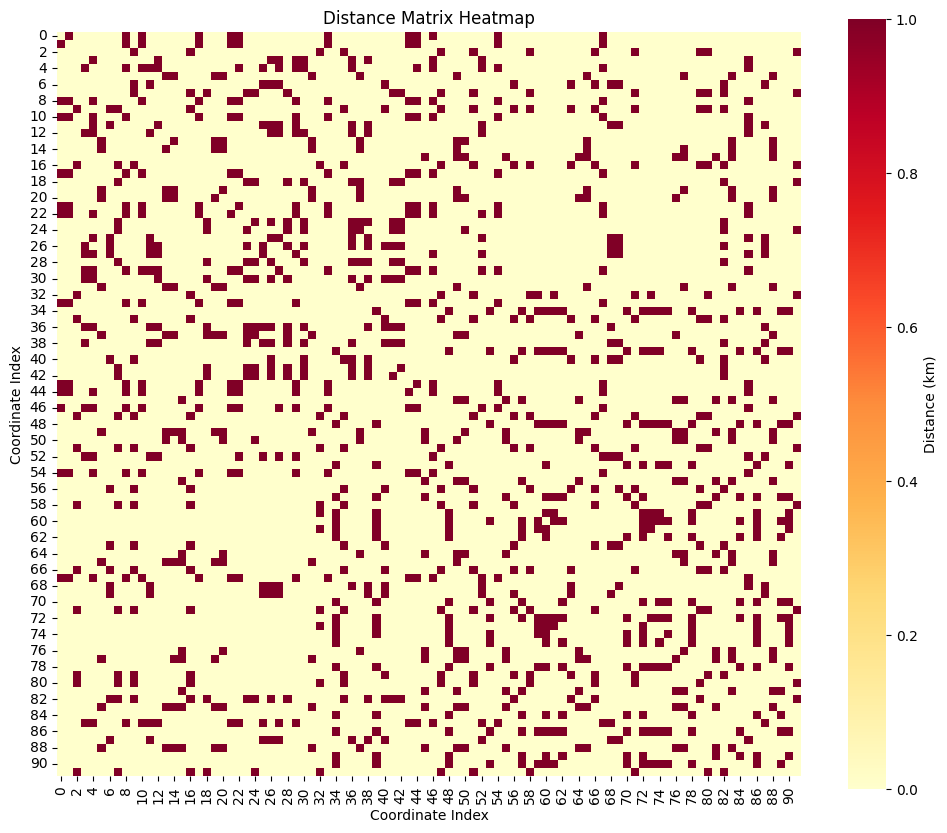

In [152]:
plot_distance_matrix_heatmap(adj_init)

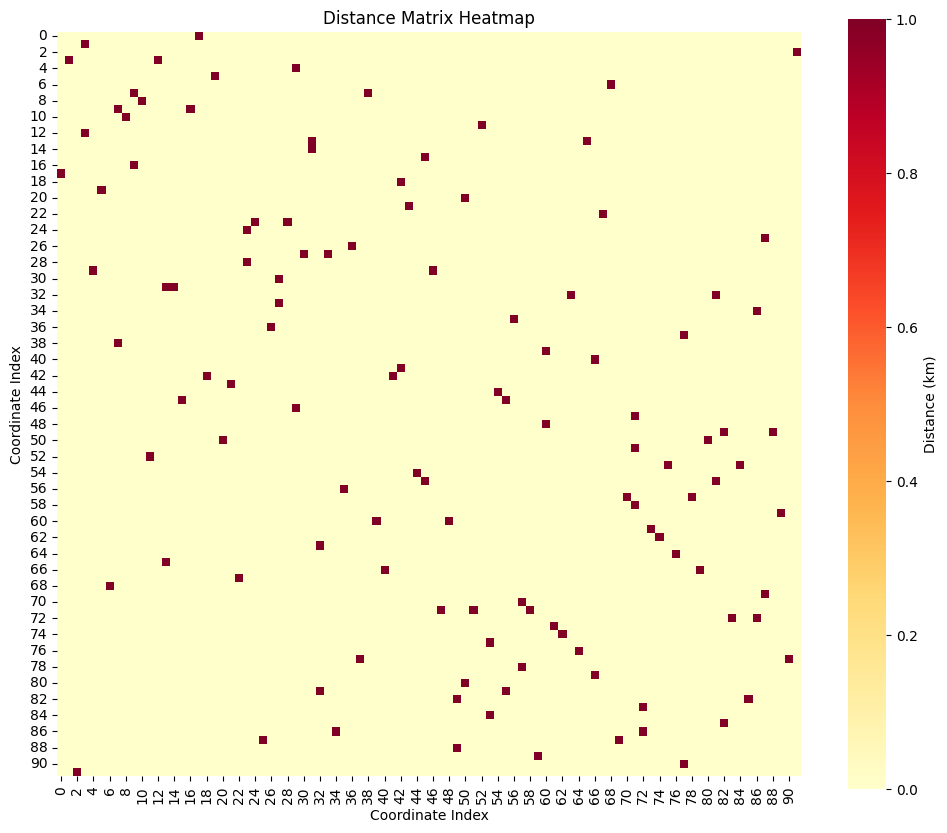

In [153]:
plot_distance_matrix_heatmap(adj_final)

In [154]:
df_map

,latitude_IG,longitud_IG
field_numb,,
RZUA01,3.555860,-73.411659
RZUA02,3.552269,-73.411659
RZUA04,3.544981,-73.411514
RZUA05,3.541357,-73.411571
RZUA06,3.537848,-73.411489
...,...,...
RZUH09,3.527172,-73.386423
RZUH10,3.523509,-73.386542
RZUH11,3.519590,-73.386250


In [155]:
import geopandas as gpd
import networkx as nx
import matplotlib.colors as mcolors
import matplotlib.pyplot as plt

In [156]:
#función que permite plotear nodos en posición geográfica deseada
def same_posicion_data(df):
  gps_point = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df.longitud_IG, df.latitude_IG)) #objeto geometrico para respetar posiciones
  coordinates = np.column_stack((gps_point.geometry.x, gps_point.geometry.y))
  return coordinates

In [157]:
coordinates = same_posicion_data(df_map)

In [158]:
graphs_[0]

Data(x=[92, 8], edge_index=[2, 118])

In [159]:
coordinates

array([[-73.411659 ,   3.55586  ],
       [-73.4116585,   3.5522694],
       [-73.4115144,   3.5449814],
       [-73.4115714,   3.541357 ],
       [-73.4114886,   3.5378482],
       [-73.4113688,   3.53451  ],
       [-73.4116395,   3.5306852],
       [-73.4120533,   3.5270875],
       [-73.4117267,   3.5232767],
       [-73.4080305,   3.5558748],
       [-73.4079323,   3.548788 ],
       [-73.408125 ,   3.5452143],
       [-73.4080353,   3.5414035],
       [-73.4073639,   3.5377706],
       [-73.4079365,   3.5339204],
       [-73.4078713,   3.5305841],
       [-73.4079213,   3.5269836],
       [-73.4083064,   3.5235147],
       [-73.4076433,   3.520385 ],
       [-73.4046697,   3.5556609],
       [-73.4042293,   3.5522801],
       [-73.4044693,   3.5486698],
       [-73.4043366,   3.5414907],
       [-73.4043351,   3.537707 ],
       [-73.4044158,   3.5340425],
       [-73.404327 ,   3.5306657],
       [-73.4042486,   3.5269262],
       [-73.4041044,   3.5234838],
       [-73.4044419,

In [160]:
graphs_[0]

Data(x=[92, 8], edge_index=[2, 118])

In [161]:
def pyg_to_networkx(data):
    # Convert PyG data to NetworkX graph
    G = nx.Graph()
    
    # Add nodes
    G.add_nodes_from(range(data.num_nodes))
    
    # Add edges
    edges = data.edge_index.t().numpy()
    G.add_edges_from(edges)
    
    # Optionally add node and edge attributes
    if data.x is not None:
        nx.set_node_attributes(G, {i: data.x[i].numpy() for i in range(data.num_nodes)}, 'features')
    
    if data.edge_attr is not None:
        edge_attrs = {tuple(edge): data.edge_attr[i].numpy() for i, edge in enumerate(edges)}
        nx.set_edge_attributes(G, edge_attrs, 'attributes')
    
    return G

In [162]:
G = pyg_to_networkx(graphs_[0])
nodes = list(G.nodes())
positions = dict(zip(G.nodes, coordinates))

In [163]:
edge_weights = [1 for u, v in G.edges()]

/home/andrescastro/miniconda3/envs/PytorchGeometric/lib/python3.10/site-packages/networkx/drawing/nx_pylab.py:457: UserWarning:

No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored



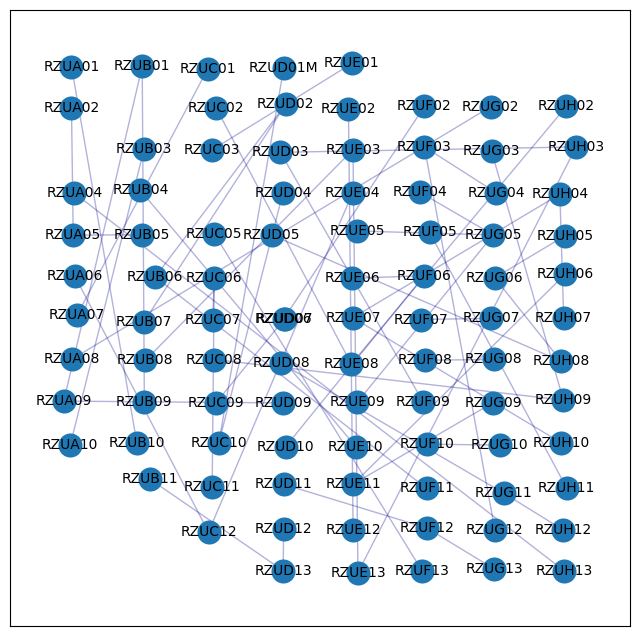

In [164]:
# Dibujar los nodos del grafo con tamaño personalizado
node_size = 300
# node_color = colores
node_border_color = 'white'
node_border_width = 0
node_labels = {node: df_map.index[node] for node in G.nodes()}

fig, ax = plt.subplots(figsize=(8,8))
nx.draw_networkx_nodes(graphs_[0], positions, nodelist=G.nodes(), node_size=node_size,# node_color=node_color,
                       linewidths=node_border_width, edgecolors=node_border_color, cmap="summer")
nx.draw_networkx_labels(G, positions, labels=node_labels, font_color='black', font_size=10)

# escalar los anchos de los enlaces
min_width = 1  # ancho mínimo de enlace
max_width = 5  # ancho máximo de enlace
# scaled_widths = [(w - min(edge_weights)) / (max(edge_weights) - min(edge_weights)) * (max_width - min_width) + min_width for w in edge_weights] #si valor de enlace es cercano al umbral, el color se acercará al azul, si es mucho mayor al umbral se acerca al rojo


# Dibujar los enlaces del grafo con ancho constante y colores personalizados
nx.draw_networkx_edges(G, positions, width=edge_weights, edge_color="darkblue", alpha=0.3) # se puede ver tambien con colores cambiando edge_color=edge_colors
# fig.savefig('./results/graph_geo.pdf', transparent=True, dpi=300,bbox_inches='tight',pad_inches=0.0)

In [165]:
import seaborn as sns

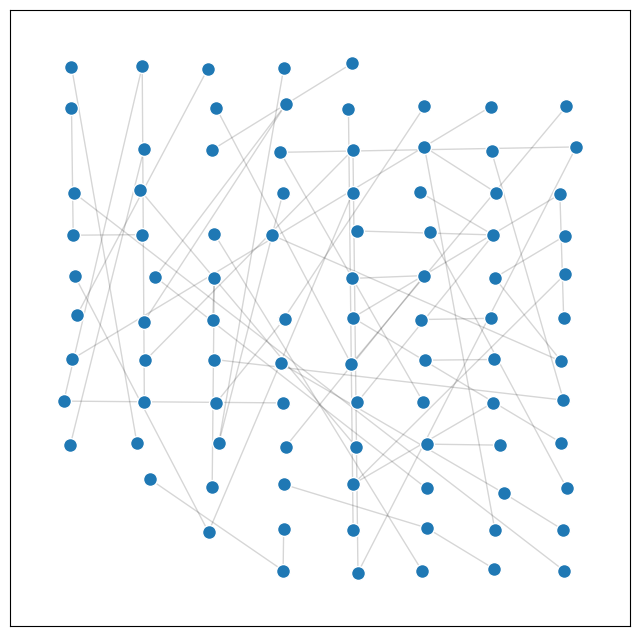

In [166]:
# with plt.style.context("seaborn-v0_8-whitegrid"):
fig, ax = plt.subplots(figsize=(8,8))
nx.draw_networkx_nodes(G, pos=positions, ax=ax, node_size=100, edgecolors="white", linewidths=1)
nx.draw_networkx_edges(G, pos=positions, width=edge_weights, alpha=0.1618, ax=ax)
fig.savefig(f'./results/graph_edges_{features}.pdf', transparent=True, dpi=300,bbox_inches='tight',pad_inches=-0.4)

In [167]:
from datashader.bundling import hammer_bundle

In [168]:
nodes_py = [[name, a[0], a[1]] for name, a in zip(nodes, positions.values())]
ds_nodes = pd.DataFrame(nodes_py, columns=['name', 'x', 'y'])       

ds_edges_py = [[n0, n1] for (n0, n1) in G.edges]
ds_edges = pd.DataFrame(ds_edges_py, columns=['source', 'target'])

hb = hammer_bundle(ds_nodes, ds_edges)

<Axes: xlabel='x'>

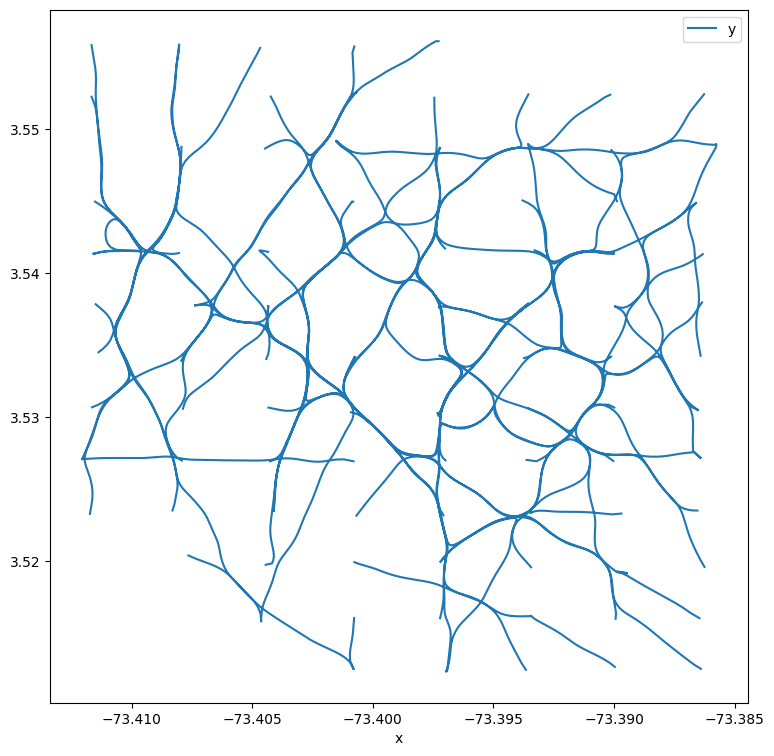

In [169]:
hb.plot(x="x", y="y", figsize=(9,9))

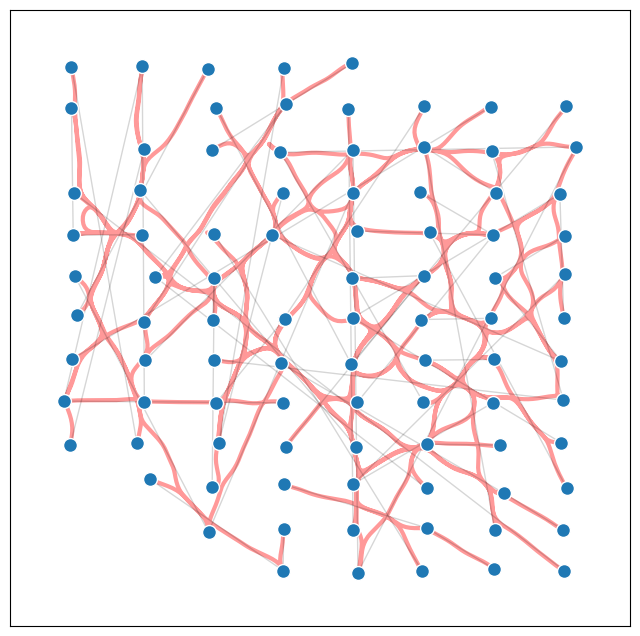

In [170]:
# with plt.style.context("seaborn-v0_8-whitegrid"):
fig, ax = plt.subplots(figsize=(8,8))
ax.plot(hb.x, hb.y, 'r', zorder=1, linewidth=3, alpha=0.4)
nx.draw_networkx_nodes(G, pos=positions, ax=ax, node_size=100, edgecolors="white", linewidths=1)
nx.draw_networkx_edges(G, pos=positions, width=edge_weights, alpha=0.1618, ax=ax)
fig.savefig(f'./results/graph_edgebund_{features}.pdf', transparent=True, dpi=300,bbox_inches='tight',pad_inches=-0.4)

In [171]:
# Extract latitudes and longitudes from dataframe
locations = df_map.reset_index().rename(columns={'index': 'name'})
lats = locations['latitude_IG'].values
lons = locations['longitud_IG'].values

bounds = (np.min(lats), np.max(lats), np.min(lons), np.max(lons))

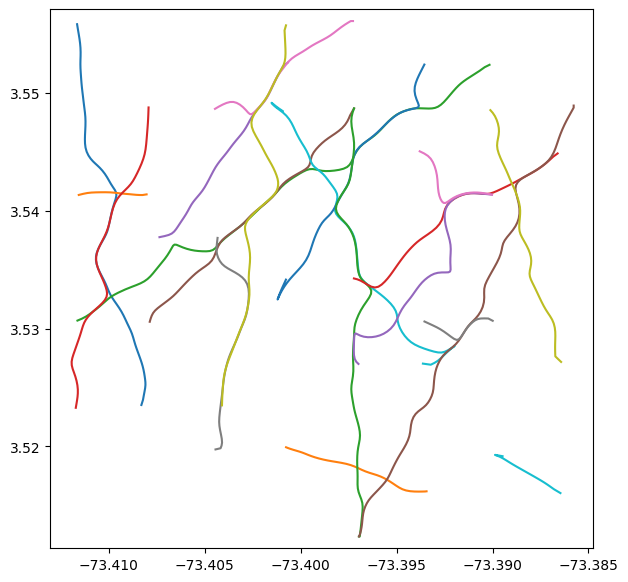

In [172]:
hbnp = hb.to_numpy()
splits = (np.isnan(hbnp[:,0])).nonzero()[0]

start = 0
segments = []
for stop in splits:
    seg = hbnp[start:stop, :]
    segments.append(seg)
    start = stop

fig, ax = plt.subplots(figsize=(7,7))
for seg in segments[::3]:
    ax.plot(seg[:,0], seg[:,1])
    ax.set_xlim(bounds[2]-0.001, bounds[3]+0.001)
    ax.set_ylim(bounds[0]-0.001, bounds[1]+0.001)

/home/andrescastro/miniconda3/envs/PytorchGeometric/lib/python3.10/site-packages/networkx/drawing/nx_pylab.py:457: UserWarning:

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.



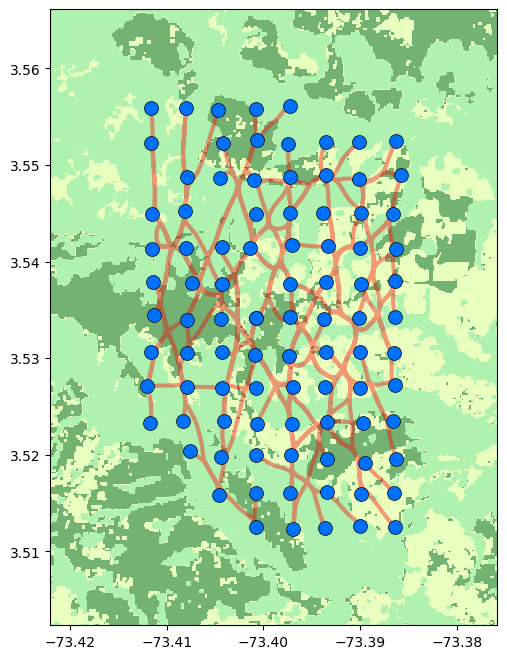

In [173]:
from matplotlib.colors import LinearSegmentedColormap
import rasterio
from rasterio.plot import show

colors = [(115/255,178/255,115/255),(233/255,255/255,190/255), (174/255,241/255,176/255)] 
cmap = LinearSegmentedColormap.from_list('my_cmp', colors, N=3)


tif_path = r'./data/wgs84.tif'

img = rasterio.open(tif_path)

fig, ax = plt.subplots(figsize = (8, 8))

# plt.title("COB")
r = rasterio.plot.show(img, cmap=cmap, ax=ax)

# im = r.get_images()[0]
# fig.colorbar(im, ax=ax)


nx.draw_networkx_nodes(G, pos=positions, ax=ax, node_size=100, edgecolors="black", linewidths=0.5, node_color=(0,112/255,255/255), hide_ticks=False)
# nx.draw_networkx_edges(G, pos=positions, width=edge_weights, alpha=0.618, ax=ax, hide_ticks=False)
ax.plot(hb.x, hb.y, 'r', zorder=1, linewidth=3, alpha=0.4)


margin = 0.01
ax.set_xlim(bounds[2]-margin, bounds[3]+margin)
ax.set_ylim(bounds[0]-margin, bounds[1]+margin)

fig.savefig(f'./results/graph_eb_geo_{features}.pdf', transparent=True, dpi=300,bbox_inches='tight',pad_inches=-0.4)
plt.show()


In [174]:
embeddings.shape

torch.Size([92, 8])

In [175]:
df_map

,latitude_IG,longitud_IG
field_numb,,
RZUA01,3.555860,-73.411659
RZUA02,3.552269,-73.411659
RZUA04,3.544981,-73.411514
RZUA05,3.541357,-73.411571
RZUA06,3.537848,-73.411489
...,...,...
RZUH09,3.527172,-73.386423
RZUH10,3.523509,-73.386542
RZUH11,3.519590,-73.386250


In [176]:
df_inter = pd.DataFrame(embeddings, columns=[f'col_{i}' for i in range(embeddings.shape[1])])
# df_inter = pd.concat([df_inter, df_map], axis=1)
df_inter = pd.concat([ df_map.reset_index(), df_inter.reset_index()], axis=1)
df_inter

,field_numb,latitude_IG,longitud_IG,index,col_0,col_1,col_2,col_3,col_4,col_5,col_6,col_7
0,RZUA01,3.555860,-73.411659,0,0.776494,9.149036e-01,0.202454,0.127116,0.122042,0.174419,0.825336,0.361233
1,RZUA02,3.552269,-73.411659,1,0.908103,1.000000e+00,0.081775,0.000000,0.000000,0.044317,0.943115,0.436360
2,RZUA04,3.544981,-73.411514,2,0.758916,6.343787e-01,0.247624,0.205097,0.295092,0.192651,0.697938,0.724546
3,RZUA05,3.541357,-73.411571,3,0.953728,8.401776e-01,0.108950,0.067665,0.022663,0.050219,0.933872,0.539142
4,RZUA06,3.537848,-73.411489,4,0.213338,4.272745e-01,0.763894,0.738646,0.685003,0.758323,0.296347,0.112953
...,...,...,...,...,...,...,...,...,...,...,...,...
87,RZUH09,3.527172,-73.386423,87,0.819669,7.148437e-01,0.242561,0.211492,0.194262,0.213198,0.790415,0.565245
88,RZUH10,3.523509,-73.386542,88,0.028771,3.471678e-16,0.908040,0.967322,0.965257,0.927044,0.092292,0.348691
89,RZUH11,3.519590,-73.386250,89,0.849888,5.696785e-01,0.143838,0.159489,0.206075,0.144648,0.841897,0.927005
90,RZUH12,3.516031,-73.386458,90,0.400581,2.449474e-01,0.557099,0.606756,0.641918,0.603934,0.430534,0.732797


In [177]:
embeddings[:,0]

tensor([0.7765, 0.9081, 0.7589, 0.9537, 0.2133, 0.8760, 0.7106, 0.3007, 0.4065,
        0.3045, 0.4065, 0.5682, 0.9534, 0.8832, 0.8760, 0.8970, 0.2766, 0.7765,
        0.9351, 0.8760, 0.6241, 0.5256, 0.2887, 0.8005, 0.7991, 0.8141, 0.2442,
        0.7172, 0.8005, 0.2074, 0.7097, 0.8760, 0.9251, 0.6497, 0.1839, 0.5401,
        0.2377, 0.4007, 0.3536, 0.2913, 0.4501, 0.9475, 0.9475, 0.5256, 0.4065,
        0.9065, 0.1876, 0.5057, 0.2955, 0.0288, 0.6250, 0.5057, 0.5820, 0.9985,
        0.4065, 0.9065, 0.5572, 0.5955, 0.5057, 0.8647, 0.2965, 0.9865, 0.8645,
        0.9712, 0.7534, 0.8883, 0.4255, 0.2887, 0.6944, 0.8337, 0.6280, 0.5057,
        0.1839, 0.9905, 0.8722, 1.0000, 0.7534, 0.3847, 0.5152, 0.4155, 0.6268,
        0.9172, 0.0038, 0.1481, 0.9942, 0.0000, 0.1839, 0.8197, 0.0288, 0.8499,
        0.4006, 0.7527], dtype=torch.float64)

In [178]:
df_inter.iloc[35]

field_numb        RZUD06
latitude_IG     3.534165
longitud_IG   -73.400769
index                 35
col_0           0.540071
col_1           0.486654
col_2           0.464328
col_3           0.423915
col_4           0.509106
col_5           0.423351
col_6            0.49997
col_7           0.591614
Name: 35, dtype: object

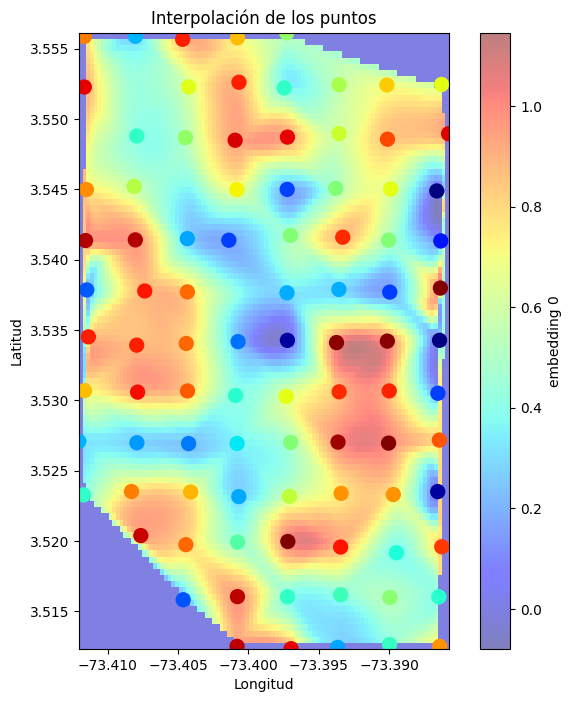

In [179]:
from shapely.geometry import Point
from scipy.interpolate import griddata

emb_sel = 0
col_sel = f'col_{emb_sel}'


# Crear un GeoDataFrame a partir del DataFrame, utilizando XCOORD.y e YCOORD.y como coordenadas de geometría
geometry = [Point(xy) for xy in zip(df_inter['longitud_IG'], df_inter['latitude_IG'])]
gdf = gpd.GeoDataFrame(df_inter, geometry=geometry)
gdf.drop(35, inplace=True)

# Cargar el archivo TIF para obtener los límites del mapa
tif_path = './data/wgs84.tif'

with rasterio.open(tif_path) as tif:
    bounds_t = tif.bounds

# Define la resolución de la cuadrícula para la interpolación
resolution = 100

# Crea una cuadrícula regular para la interpolación
x_min, x_max = gdf['longitud_IG'].min(), gdf['longitud_IG'].max()
y_min, y_max = gdf['latitude_IG'].min(), gdf['latitude_IG'].max()
x_grid = np.linspace(x_min, x_max, resolution)
y_grid = np.linspace(y_min, y_max, resolution)
X, Y = np.meshgrid(x_grid, y_grid)

# Realiza la interpolación utilizando griddata
Z2 = griddata((gdf['longitud_IG'], gdf['latitude_IG']), gdf[col_sel], (X, Y), method='cubic',fill_value=0)

fig, ax = plt.subplots(figsize=(8,8))

# Visualiza los puntos originales
gdf.plot(ax=ax, column=col_sel, cmap='jet', markersize=100)#, legend=True)

# Visualiza la interpolación como un mapa de calor
im = ax.imshow(Z2, origin='lower', extent=[x_min, x_max, y_min, y_max], cmap='jet', alpha=0.5)
plt.colorbar(im, ax=ax, label=f'embedding {emb_sel}')
limited_dataimg = im.get_array()

# ax.plot(hb.x, hb.y, 'r', zorder=1, linewidth=3, alpha=0.4)

ax.set_title('Interpolación de los puntos')
ax.set_xlabel('Longitud')
ax.set_ylabel('Latitud')
plt.show()

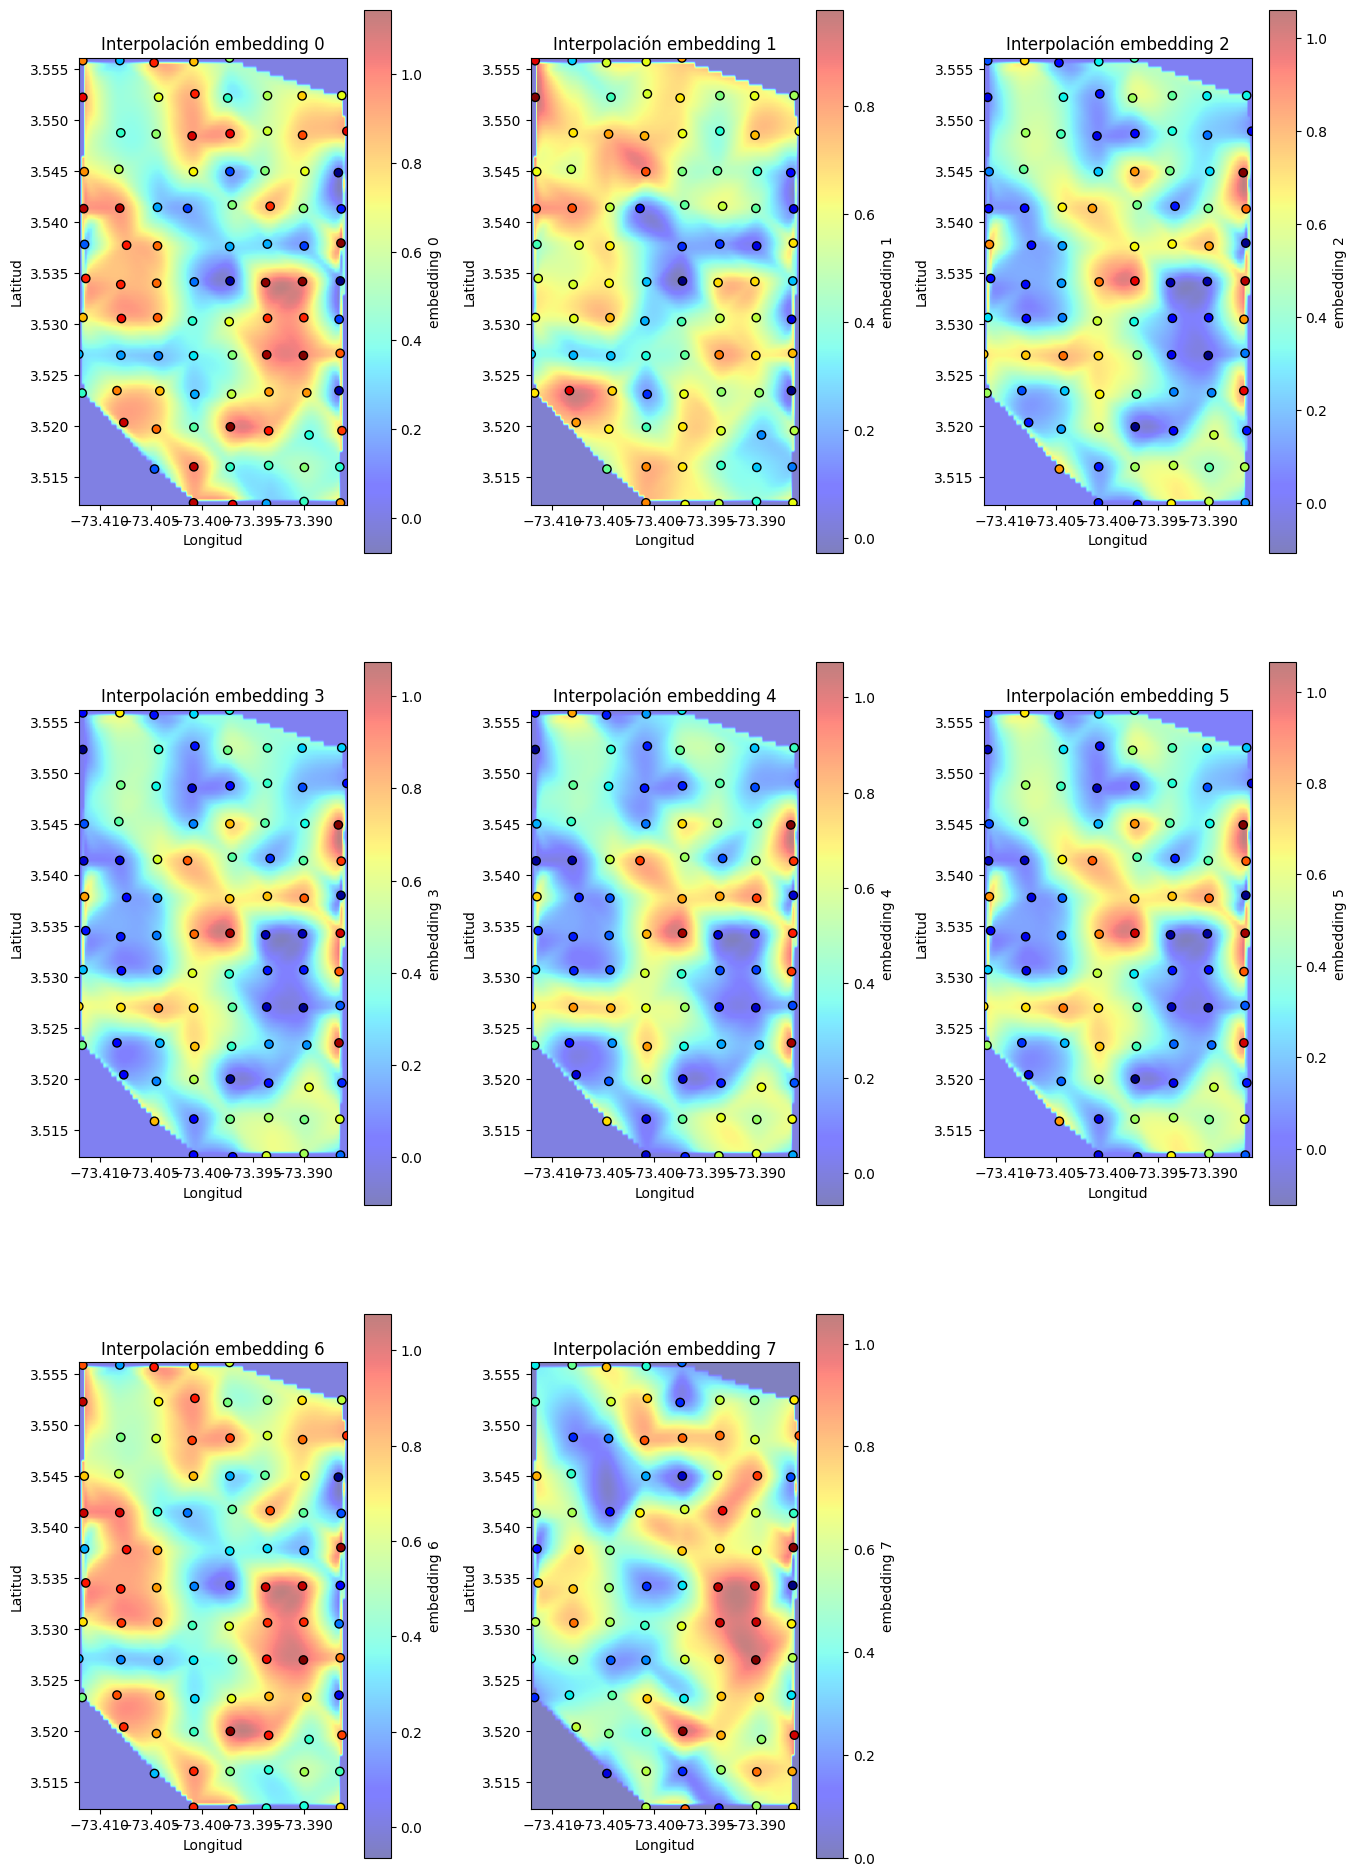

In [180]:
# Create a 4x2 subplot grid
fig, axes = plt.subplots(3, 3, figsize=(16, 24))
axes = axes.ravel()  # Flatten the 2D array of axes for easier iteration

# Cargar el archivo TIF para obtener los límites del mapa
tif_path = './data/wgs84.tif'
with rasterio.open(tif_path) as tif:
   bounds_t = tif.bounds

# Define la resolución de la cuadrícula para la interpolación
resolution = 100

# Crear un GeoDataFrame a partir del DataFrame
geometry = [Point(xy) for xy in zip(df_inter['longitud_IG'], df_inter['latitude_IG'])]
gdf = gpd.GeoDataFrame(df_inter, geometry=geometry)
gdf.drop(35, inplace=True)

# Crea una cuadrícula regular para la interpolación
x_min, x_max = gdf['longitud_IG'].min(), gdf['longitud_IG'].max()
y_min, y_max = gdf['latitude_IG'].min(), gdf['latitude_IG'].max()
x_grid = np.linspace(x_min, x_max, resolution)
y_grid = np.linspace(y_min, y_max, resolution)
X, Y = np.meshgrid(x_grid, y_grid)

# Generar gráficas para cada embedding
for emb_sel in range(8):
   col_sel = f'col_{emb_sel}'
   
   # Realiza la interpolación utilizando griddata
   Z2 = griddata((gdf['longitud_IG'], gdf['latitude_IG']), gdf[col_sel], (X, Y), method='cubic', fill_value=0)
   
   # Selecciona el subplot actual
   ax = axes[emb_sel]
   
   # Visualiza la interpolación como un mapa de calor
   im = ax.imshow(Z2, origin='lower', extent=[x_min, x_max, y_min, y_max], cmap='jet', alpha=0.5)
   
   # Añade los puntos originales
   scatter = ax.scatter(gdf['longitud_IG'], gdf['latitude_IG'], c=gdf[col_sel], cmap='jet', edgecolors='black')
   
   # Añade colorbar
   plt.colorbar(im, ax=ax, label=f'embedding {emb_sel}')
   
   # Configura título y etiquetas
   ax.set_title(f'Interpolación embedding {emb_sel}')
   ax.set_xlabel('Longitud')
   ax.set_ylabel('Latitud')

axes[8].set_axis_off()
# Ajusta el layout para evitar solapes
plt.subplots_adjust(wspace=0.35, hspace=0.2)

fig.savefig(f'./results/interp_emb_{features}.pdf', transparent=True, dpi=300,bbox_inches='tight',pad_inches=0.0)


# Muestra todas las gráficas
plt.show()
